#**Week 3 - Convolutional Neural Networks** (~1 hr total)

## Part 0 - Setup (~1 min)
Before you begin, please clone this notebook!

**File > Save a copy in Drive**

In [1]:
from logging import exception
#@title Step 1: Mount drive
#@markdown Run this cell. If prompted, press "Connect to Google Drive" and select your Google account.
#@markdown Then, under the folder icon 📁 on the left panel, you should see the folder **drive** appear.
from google.colab import drive
from IPython.display import display, Markdown, HTML
import os, sys

%load_ext autoreload
%autoreload 2
try:
  drive.mount('/content/drive', force_remount=False)
  sys.path.append('/content/drive/MyDrive/DLE-Jun23/Projects')
  os.chdir('/content/drive/MyDrive/Colab Notebooks/')
  display("⭐ Mounted successfully!")
except:
  display(HTML('<span style="color:red">An error occurred. Try again!</span>'))


Mounted at /content/drive


'⭐ Mounted successfully!'

In [2]:
#@title Step 2: Import packages

%%capture
%load_ext autoreload
%autoreload 2

!pip install gradio wandb fsspec dask[bag]
from dle_utils.dle_utils import *
from dle_utils.train import *

%autoreload 2
import gradio as gr
import torch
torch.backends.cudnn.benchmark = True
import io
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
import wandb
import pandas as pd
from scipy.special import softmax
from sklearn.metrics import accuracy_score, f1_score, classification_report
import imageio
import torchvision

from torchvision import transforms, utils
from PIL import Image
import random
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
#@title Step 3: Enter your name to begin
#@markdown Enter your name as it appears in Slack and run this cell!
Name = ' ' #@param {type:"string"}
filepath = '/content/drive/MyDrive/Colab Notebooks/dle_info.txt'
if os.path.exists(filepath):
  print("Success!")
else:
  try:
    with open(filepath, 'w') as fp:
      fp.write(Name)
      dle_username = Name
    print("Success!")
  except:
    print("Something went wrong...")


# Welcome to Week 3!

This week, we'll be using our knowledge of building and training neural networks toward computer vision!

## Overview of Week 3

1. Building blocks (Convolutions, Pooling Layers)
  - First, you will be exploring the convolutional operation in PyTorch. Here, you'll get hands-on intuition for what happens under the hood of a Convolutional layer.
2. Convolutional neural networks
  - Building upon our model training and evaluation experience from Week 1, you will write, train, and evaluate your own convolutional neural network.
  - You will visualize your model outputs as embeddings.
4. CNN Model Zoo
  - Finally, you will experiment with different vision models and compare how they perform to your "vanilla" CNN! Some examples include:
    - ResNet18
    - RCNN
    - Vision Transformers

# Part 1: Basics of CNNs

## Step 1: The Convolutional Layer

Convolutional Neural Networks (CNNs) are the model of choice for most computer vision tasks, and they are behind the massive advances made in AI over the last 10 years. At the very core of CNNs are the convolutional layer. When you think of CNNs, you can think of many stacked convolutional layers.

<img src="https://drive.google.com/uc?id=1iDkeAz-6Z0sysulWA3wvNid3AO0yayJR" width="600">

In this first part, we will be probing into the convolutional layer. The goal here is to develop a deeper intuition for how and why they work!

To implement a convolutional layer in PyTorch, just use ```nn.Conv2d()```.

Read the documentation for this layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and implement a 2D convolutional layer with 1 input channel, 3 output channel, and a 5x5 kernel:




In [ ]:
# TODO: Implement a 2D convolutional layer with 1 input channel, 3 output channel, and a 5x5 kernel

conv_layer = nn.Conv2d(1,3,(5,5))

check('3.1.1', conv_layer)

Error: Please set your name first!


## Correct! 🎉

Let's investigate this layer!

First, we will look at the weights. In the cell below, store and print the shape of ```conv_layer```'s weights.

In [ ]:
# TODO: Compute and print the shape of the weights of conv_layer

weights_shape = conv_layer.weight.shape
print(weights_shape)
check('3.1.2', weights_shape)

torch.Size([3, 1, 5, 5])


## Correct! 🎉

In [ ]:
from IPython.display import display, Markdown
#@title Pop Quiz! { vertical-output: true, form-width: "500px" }
#@markdown
#@markdown #####  Without writing any code, what is the first dimension of the following layer's weights? (Or in Python, the 0th)
#@markdown ```nn.Conv2d(32, 64, 7)```

Answer =  64#@param {type:"integer"}

#@markdown (Run cell to submit.)

if Answer == 64:
  display(Markdown('''
  ### ***Correct! 🎉***
  There are four dimensions to the weights of a convolutional layer:

  The first dimension is the number of output channels, the second dimension is the number of input channels, and the last two dimensions are the kernel size.
  '''))
else:
  display(Markdown('### Answer is incorrect, try again!'))


  ### ***Correct! 🎉***
  There are four dimensions to the weights of a convolutional layer:

  The first dimension is the number of output channels, the second dimension is the number of input channels, and the last two dimensions are the kernel size.
  

Next, let's feed data through this layer to see what it does to it.

Notice that we'll need to add a "channel" dimension to an image in order to feed it through the layer.

In the cell below, create a PyTorch tensor with dimensions (1, 64, 64) and print out the dimensions of the output from the layer.

In [ ]:
# TODO: Create input -- PyTorch tensor of zeros with dimension (1, 64, 64)
input_image = torch.zeros(1,64,64)

# TODO: Feed it through conv_layer
conv_output = conv_layer(input_image)

# TODO: Print the shape of conv_output
print(conv_output.shape)

check('3.1.3', conv_output)

torch.Size([3, 60, 60])


## Correct! 🎉

Notice that the shape of the image has changed!

It went from one "slice" of a 64x64 image to three "slices" of 60x60.

So what happened?

The convolutional operation cuts off part of the edges of the input image (this was covered in the lecture slides). Additionally, it creates three copies of the input image and performs separate convolutional operations on each of these copies according to different kernels (remember we had 3 5x5 kernels from the weights).

In [ ]:
from IPython.display import display, Markdown
#@title Pop Quiz! { vertical-output: true, form-width: "500px" }
#@markdown
#@markdown Without running the code below, what will the last line return?

#@markdown ```input_x = torch.Tensor(64, 124, 124)```

#@markdown ```layer = nn.Conv2d(64, 128, 5)```

#@markdown ```print(layer(input_x).size())```
try:
  Answer = torch.Size([128, 120, 120]) #@param {type:"raw"}
except:
  display(Markdown('### Answer is incorrect, try again!'))
#@markdown (Run cell to submit.)

if Answer == torch.Size([128, 120, 120]):
  display(Markdown('''
  ### ***Correct!*** 🎉
  '''))
else:
  display(Markdown('''
  ### Answer is incorrect, try again!
  Hint: The convolutional layer "shaves off" 4 pixels off each side of the input image.

  An image with $n$ pixels on each side will have ($n-$ kernel_size $+1$) after passing through a convolutional layer.

  (One day, someone might ask you this in a job interview and you'll be happy to know this 😀)
  '''))


  ### ***Correct!*** 🎉
  

Next, let's see how the convolutional layers actually work! (It's kind of neat)

To do this, we will be manually specifying the weights of ```conv_layer```.

In the cell below, set the weights as the three matrices described and zero out the bias.

**TODO: First, create three PyTorch tensors:**

1. A 5x5 tensor that contains 1 on the 3rd column and zeros elsewhere:
```
    0  0  1  0  0
    0  0  1  0  0
    0  0  1  0  0
    0  0  1  0  0
    0  0  1  0  0
```
2. A 5x5 tensor that contains 1 on the 3rd row and zeros elsewhere:
```
    0  0  0  0  0
    0  0  0  0  0
    1  1  1  1  1
    0  0  0  0  0
    0  0  0  0  0
```
3. A 5x5 tensor that has 1s on the diagonal and zeros elsewhere:
```
    1  0  0  0  0
    0  1  0  0  0
    0  0  1  0  0
    0  0  0  1  0
    0  0  0  0  1
```

**Hint**: There may be multiple ways to accomplish this! Can you generate these tensors using convenient PyTorch functions?

In [ ]:
filter_1 = torch.zeros(5, 5)
filter_1[:,2]=1

filter_2 = torch.zeros(5, 5)
filter_2[2,:]=1

filter_3 = torch.eye(5)

**TODO**: Next, using your PyTorch tensor manipulation prowess, find a way to set these three filters as the weights of `conv_layer`.

Hint: you will need to turn off gradient calculation for this weight before modifying the weights (use `conv_layer.weight.requires_grad = False`).


In [ ]:
# disable gradient calculation
conv_layer.weight.requires_grad = False

# then, set each of the three filters in conv_layer.weight:
filters=torch.stack((filter_1,filter_2,filter_3)).unsqueeze(1)
print(filters.shape)

with torch.no_grad():
  conv_layer.weight = nn.parameter.Parameter(filters)
conv_layer.weight

torch.Size([3, 1, 5, 5])


Parameter containing:
tensor([[[[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.]]],


        [[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]],


        [[[1., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 1.]]]], requires_grad=True)

**TODO**: Finally, set all the values of the bias to zero.

Hints: Create a PyTorch tensor of size (3) with zeros. Then, wrap it in a `torch.nn.Parameter` object. Like before, remember to turn off gradients!

In [ ]:
conv_layer.bias.requires_grad = False
conv_layer.bias = torch.nn.Parameter(torch.zeros(3))


In [ ]:
#@markdown ### Run this cell to check your answer!
check('3.1.4', conv_layer)
# check_answer(all(np.linalg.eig(conv_layer.weight[0][0].detach().numpy())[0]==[0., 0., 0., 0., 1.]) and \
#              all(np.linalg.eig(conv_layer.weight[1][0].detach().numpy())[0] == [1., 0., 0., 0., 0.]) and \
#              all(np.linalg.eig(conv_layer.weight[2][0].detach().numpy())[0] == [1., 1., 1., 1., 1.]))

## Correct! 🎉

Now that we've set up our own convolutional layer, let's see how it works!

**TODO**: Run the cell below.

In the sketchpad, draw any shape (start with a circle). This is just intuition building for you -- notice what parts of the shape are highlighted for each filter.

Remember, the first filter is a vertical line, the second is a horizontal line, and the third is a diagonal.

If you did the above correctly, then you should be able to just press run on the demo below!

**Hint**: If the demo is hanging, there might be a bug! Stop the cell and debug and try again.

In [ ]:
def get_filters(image):
    if image is None: return
    image = 1. - image / 255.
    pt_input = torch.Tensor(image).view(1, 1, image.shape[0], image.shape[1])
    conv_output = conv_layer(pt_input).detach().numpy()[0]
    num_filters = conv_output.shape[0]
    fig, axes = plt.subplots(1, num_filters)
    fig.set_size_inches(8, 4)
    fig.tight_layout(pad=0.5)

    for i in range(num_filters):
        ax = axes[i]
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.imshow(conv_output[i], cmap='seismic_r')
        ax.title.set_text(f'Convolution w/ \n filter {i+1}')

    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()

    return data

see_filters = gr.Interface(get_filters, inputs='sketchpad', outputs='image', live=True).launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


Great 🎉 ! Hopefully, you will see that the reason why kernels work is because they highlight different features in the image, depending on what the values are!

### Bonus steps!

Here are a few things you can try to gain a greater understanding of what the convolutional filters are doing:

1. See what happens when you draw something on the border. The output of the convolutional layer seems to get cut off! This is partially due to the fact that the image shrinks. In defining the Conv2d layer, there is a parameter called ```padding```. Setting ```padding='same'``` will add zeros to the input before passing it through. Add this parameter in and see if this helps when you are drawing things near the border!

2. Are there other types of filters you can think of that show distinct patterns when used? Feel free to go back to the previous cells to change them around.

3. Try changing the size of the kernel to 3 or 7. How do the output images look?

## Step 2: Pooling layers

Pooling layers are commonly combined with convolutional layers to improve model efficiency and power. Let's gain some intuition on what's going on when we use a pooling layer.

PyTorch has two types of pooling layers: [`MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), and [`AvgPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Each takes a parameter, `kernel_size`, which determines by what factor to pool the image by.

Visualize the following puppy below:

In [ ]:
# The image is loaded into img
img = torch.tensor(imageio.imread('/content/drive/My Drive/DLE-Jun23/Projects/dle_utils/puppy.jpeg')).permute(2, 0, 1)/255.

plt.imshow(img.permute(1, 2, 0))
plt.show()
# Note: permute() moves the channel dimension to end.
# We do this to follow Matplotlib convention of "channels last", while PyTorch is "channels first"

<ipython-input-21-df8f91f2a0cf>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = torch.tensor(imageio.imread('/content/drive/My Drive/DLE-Jun23/Projects/dle_utils/puppy.jpeg')).permute(2, 0, 1)/255.


**TODO**: Given the image in ```img```, visualize the images that are outputted by 1) average pooling, and 2) max pooling. For both, use a kernel size of 8.

In [ ]:

# TODO: Create a nn.AvgPool2d() layer with kernel size of 8 and apply it to the image.
avg_pool = nn.AvgPool2d(kernel_size=8)
# TODO: Visualize the image.
plt.imshow(avg_pool(img).permute(1,2,0).numpy())
plt.show()

# TODO: Do the same with a nn.MaxPool2d layer of kernel size of 8.
max_pool = nn.MaxPool2d(kernel_size=8)
plt.imshow(max_pool(img).permute(1,2,0).numpy())
plt.show()

check('3.1.5', [avg_pool, max_pool])


## Correct! 🎉

As you'll notice, both layers accomplish similar tasks -- reducing the dimension of the image while preserving the general gist of it!

Can you think of some differences in the image and how taking average would be different than taking a max?

# Part 2: Putting It Together

Now we know how convolutional filters work! Let's use this to create full-scale CNNs.

## Step 1: Convolutional Neural networks

Our goal this week is to *improve* the model that you trained in Week 1, this time with convolutional layers.

Notice that in Week 1, all of our neural network training was performed on the CPU. This week, as we scale up the size of our models, we will harness the power of GPUs!

PyTorch makes this simple to do. In order to train on GPUs, PyTorch needs to first know the name of the GPU device we hope to train on. This is done by:

    device = torch.device('cuda')

*Cuda* is the name of the library that performs neural network operations on the GPU. Now, we use the `device` variable to send *1) data* and *2) weights* to the GPU. We can do this with the `.to(device)` call.

For instance, to send a PyTorch Tensor `x` to GPU, do:

    x.to(device)

Below, we have included a reference implementation of the `EmojiDataset` class that you completed in Week 1, along with the data sets and data loaders.

**TODO**: First, in the `__getitem__` method, reshape the input tensor x to (1, 28, 28). Then, send the `x` and `y` variables to GPU.

In [3]:
device = torch.device('cuda')

class EmojiDataset(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.class_names = list(DOODLE_TO_EMOJI_MAP.keys())
        self.num_classes = 10

        self.X = np.load('/content/drive/My Drive/DLE-Jun23/Projects/dle_utils/emoji_data/emoji_X.npy')
        self.Y = np.load('/content/drive/My Drive/DLE-Jun23/Projects/dle_utils/emoji_data/emoji_y.npy')

    def __getitem__(self, idx):

        # reshape x to (1,28,28)
        x = (self.X[idx] / 255.).astype(np.float32).reshape(1,28,28)
        y = self.Y[idx]
        x = torch.from_numpy(x)
        y = torch.tensor(y.item())

        # TODO: send x and y to the GPU
        return x.to(device), y.to(device)

    def __len__(self):
        len_X = len(self.X)
        return len_X

    def split(self, pct=0.1):
        # Nothing to do here, this function just splits your data
        torch.manual_seed(0)
        indices = torch.randperm(len(self)).tolist()
        n_pct = int(np.floor(len(indices) * pct))
        train_ds = torch.utils.data.Subset(self, indices[:-(2*n_pct)])
        val_ds = torch.utils.data.Subset(self, indices[-(2*n_pct):-n_pct])
        test_ds = torch.utils.data.Subset(self, indices[-n_pct:])
        return train_ds, val_ds, test_ds


 Then, run the cell to instantiate the data sets and data loaders.

In [4]:
torch.manual_seed(0)

ds = EmojiDataset()

# The rest of this code creates the appropriate variables!
train_ds, val_ds, test_ds = ds.split(pct=0.1)

batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

check('3.2.1', train_ds)

Error: Please set your name first!


## Correct! 🎉

## Step 2: Creating the `CNN` class

In Week 1, we declared each layer in the `__init__()` method of our `MLP` class. This week, we will be using [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). This is an object in PyTorch that accepts as arguments a sequence of PyTorch layers, and automatically performs the `forward()` pass.

For instance, here is one example of how to use `nn.Sequential`:
    
    nn.Sequential(
              nn.Conv2d(1,20,5),
              nn.ReLU(),
              nn.Conv2d(20,64,5),
              nn.ReLU()
            )
    

**TODO**: Using `nn.Sequential`, create a PyTorch model class (call it `CNN`) with the following specifications. For all `Conv2d` layers, set the kernel size to `3`.

- A `Conv2D` layer with `1` input channel and `8` output channels and `ReLU` activation function
- A `Conv2D` layer with `8` input channels and `16` output channels and `ReLU` activation function
- A `MaxPool2d` layer with kernel size of `2`
- A `Conv2D` layer with `16` input channels and `32` output channels and `ReLU` activation function
- A `Conv2D` layer with `32` input channels and `64` output channels and `ReLU` activation function
- A `MaxPool2d` layer with kernel size of `2`
- A `Conv2D` layer with `64` input channels and `128` output channels and `ReLU` activation function
- A `MaxPool2d` layer with kernel size of `2`
- A `Flatten` layer with `start_dim=1` and `end_dim=-1`
- A Linear layer with `128` input nodes and `10` output nodes.

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    # TODO: Implement the layers!
    self.model = nn.Sequential(
        nn.Conv2d(1,8,3),
        nn.ReLU(),
        nn.Conv2d(8,16,3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(16,32,3),
        nn.ReLU(),
        nn.Conv2d(32,64,3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(64,128,3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(128 , 10)
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
#@title Run this cell to check your answer!
torch.manual_seed(0)
test_model = CNN()
check('3.2.2', test_model)

## Correct! 🎉

## Step 3: Training your CNN

This week we are providing you with `train` and `evaluate` functions. These will look very similar to what you implemented last week! In fact, feel free to use your own functions if you are inclined.



**TODO**: Train the `CNN` model with the following hyperparameters:
- Learning rate: `1e-4`
- Optimizer: `Adam`
- Loss function: `CrossEntropyLoss`
- Epochs: `15`
- Send the model to GPU




In [ ]:
device = torch.device('cuda')
emoji_model = CNN().to(device) # TODO: send to GPU!

# Initialize your loss function and optimizer
optimizer = torch.optim.Adam(emoji_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
train(epochs=15,
      model=emoji_model,
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn)

Training model...
Epoch  0


100%|██████████| 2500/2500 [00:22<00:00, 111.73it/s]


Epoch  1


100%|██████████| 2500/2500 [00:19<00:00, 125.81it/s]


Epoch  2


100%|██████████| 2500/2500 [00:19<00:00, 127.48it/s]


Epoch  3


100%|██████████| 2500/2500 [00:18<00:00, 136.22it/s]


Epoch  4


100%|██████████| 2500/2500 [00:19<00:00, 126.61it/s]


Epoch  5


100%|██████████| 2500/2500 [00:19<00:00, 130.20it/s]


Epoch  6


100%|██████████| 2500/2500 [00:18<00:00, 135.76it/s]


Epoch  7


100%|██████████| 2500/2500 [00:18<00:00, 135.81it/s]


Epoch  8


100%|██████████| 2500/2500 [00:19<00:00, 127.40it/s]


Epoch  9


100%|██████████| 2500/2500 [00:18<00:00, 135.62it/s]


Epoch  10


100%|██████████| 2500/2500 [00:18<00:00, 133.48it/s]


Epoch  11


100%|██████████| 2500/2500 [00:18<00:00, 132.37it/s]


Epoch  12


100%|██████████| 2500/2500 [00:19<00:00, 128.82it/s]


Epoch  13


100%|██████████| 2500/2500 [00:18<00:00, 137.00it/s]


Epoch  14


100%|██████████| 2500/2500 [00:18<00:00, 133.78it/s]

Finished training successfully!


## Step 4: Evaluate your CNN!

First, play with your shiny new model in the drawing board!

In particular, try drawing objects that might challenge a neural network but rotating, translating, and resizing them.

In [ ]:

from scipy.special import softmax

def get_prediction(doodle):
  pt_input = torch.Tensor(doodle).view(1, 1, doodle.shape[0], doodle.shape[1]).to(device)
  y_hats = emoji_model(pt_input).detach().cpu().numpy()[0]
  y_hats = softmax(y_hats)
  return y_hats

def predict(doodle):
  if doodle is None:
    return
  doodle = doodle / 255.
  y_hats = get_prediction(doodle)
  emoji_names = np.array(list(DOODLE_TO_EMOJI_MAP.values()))
  emoji_dict = {emoji_names[i]: float(y_hat) for i, y_hat in enumerate(y_hats)}
  return emoji_dict

interface = gr.Interface(predict, inputs='sketchpad', outputs='label', theme="default", live=True, description="Guess the Doodle!")
interface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


### How did you do?

Let's see how well your function does! We've created tiers to show you how well your model is performing:

**S+**: Amazing job! You've done better than the instructors at getting this to work!

**S**: You have incredible intuiiton about neural networks!

**A**: Superb and among the top tier of this class.

**B**: Congrats! You've done as well as any reasonble ML engineer would do on this project!

**C**: There might be some issues with your code since the baseline is higher than the score you got :)

We encourage you to edit your model with all the knowledge that you have now and see how much you can improve your model!


In [ ]:
#@title How did your model do?
#@markdown Run this cell to evaluate your model on the test dataset!
#@markdown (Make sure that your model is named `emoji_model`).
accuracy = evaluate(emoji_model, test_dataloader)
print(f"Model accuracy: {accuracy}")

display(md((f'Your test accuracy is {accuracy}.')))

tier_dict = {'C': .5, 'B': .7, 'A': .75, 'S': .8, 'S+': .85}
for tier in ['C', 'B', 'A', 'S', 'S+']:
    if accuracy < tier_dict[tier]:
        break

display(md(f'## Performance Tier: {tier}.'))
if tier in ['A', 'S', 'S+']:
  display(md(f'Amazing job! Your model has excellent performance.'))
else:
  display(md(f'Great job! Now, see if changing some hyperparameters can improve your model even more!'))

check('3.2.3', accuracy)


Evaluating model...


100%|██████████| 313/313 [00:01<00:00, 199.55it/s]

Model accuracy: 0.9108


Your test accuracy is 0.9108.

## Performance Tier: S+.

Amazing job! Your model has excellent performance.

## Correct! 🎉

Great! Hopefully your CNN outperforms the MLP that you trained from last week.

# Part 3: Using pre-trained models

We've trained our own CNN from scratch - fantastic! Now, we're going to use some help. In this section, we will be using pre-trained models for classification.

Head over to the [PyTorch Model Zoo page](https://pytorch.org/serve/model_zoo.html). You'll notice several dozen pre-trained models to choose from. We'll be using three in particular:
- [Resnet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18)
- [MobileNet v3](https://pytorch.org/vision/stable/models/generated/torchvision.models.mobilenet_v3_small.html#torchvision.models.mobilenet_v3_small)
- [Vision Transformer](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16)

In PyTorch, loading and using pre-trained models have a standard, convenient interface.

**TODO**: Create a `Resnet18` model using default weights. Extract the transform function used for training the default weights. Remember to send the model to the GPU.

**Hint**: Rely on the link above ([Resnet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18)) for documentation on how to use this model!

In [8]:
from torchvision.models import resnet18, ResNet18_Weights
resnet = resnet18(weights='DEFAULT').to(device)
resnet_transforms = ResNet18_Weights.DEFAULT.transforms()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


**TODO**: Get the image of the first item in in `train_ds`. Pass it through the Resnet18 model and produce the prediction. What is the shape of the output vector?

In [9]:
# we've included a helpful tranform function to get the output of your data loader to match the input of the model
my_transform = lambda x: resnet_transforms(x.repeat(1, 3, 1, 1))

# TODO: pass the image of the first item in train_ds (train_ds[0][0]) through my_transform, and then send it to GPU.
output = my_transform(train_ds[0][0]).to(device)

resnet(output).shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 1000])

**TODO**: Now, replace the last layer with a Linear layer that has the same number of input nodes but with 10 output nodes.

In [ ]:
# this is the number of input nodes in the resnet model's last layer
num_features = resnet.fc.in_features

# Create a nn.Linear layer. Set the input nodes = num_features and output nodes = 10. Send it to GPU.
resnet.fc = nn.Linear(num_features, 10).to(device)

**TODO**: Train this model using the same `train` function as in Part 2 Step 3 and evaluate its accuracy.

**Note**: This may take up to 10 minutes! Train for 1 epoch.

In [ ]:
train(epochs=1,
      model=resnet,
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader,
      transform=my_transform)

accuracy = evaluate(resnet, test_dataloader, transform=my_transform)
print("Accuracy: ", accuracy)


Training model...
Epoch  0


100%|██████████| 2500/2500 [07:43<00:00,  5.39it/s]


Finished training successfully!
Evaluating model...


100%|██████████| 313/313 [00:19<00:00, 15.94it/s]

Accuracy:  0.9451


Congrats! Hopefully your model performs significantly better than the original CNN.

### Bonus step!

How do other models perform?

**TODO**: Now, perform the same steps in Part 3, with mobilenet_v3_small (MobileNet v3 small) and vit_b_16 (Vision Transformer). Use `DEFAULT` weights for each.

*Hint*: Use `list(model.children())` to find the last linear layer in each model and use it to identify which layer to swap out.

**Warning**: Since these models are large, prepare to wait a while as they train! We suggest finishing the rest of this project and coming back around to this step :-).

**Hint 2**: One common strategy for fine-tuning models is only training the last layer's weights! Can you figure out how to do this? This will make training significantly faster!

In [ ]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
mobilenet = mobilenet_v3_small(weights='DEFAULT').to(device)
mobilenet_transforms = MobileNet_V3_Small_Weights.DEFAULT.transforms()
last_layer = list(mobilenet.children())[-1][-1] # find the last layer!
num_features = last_layer.in_features
last_layer = nn.Linear(num_features, 10).to(device)
train(epochs=1,
      model=mobilenet,
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader,
      transform=my_transform)

accuracy = evaluate(mobilenet, test_dataloader, transform=my_transform)
print("Accuracy: ", accuracy)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 85.3MB/s]


Training model...
Epoch  0


  0%|          | 0/2500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 2500/2500 [02:45<00:00, 15.10it/s]


Finished training successfully!
Evaluating model...


100%|██████████| 313/313 [00:08<00:00, 37.91it/s]

Accuracy:  0.9383


In [1]:
from torchvision.models import vit_b_16, ViT_B_16_Weights
vit = vit_b_16(weights='DEFAULT').to(device)
vit_transforms =ViT_B_16_Weights.DEFAULT.transforms()
last_layer = list(vit.children())[-1][-1] # find the last layer!
num_features = last_layer.in_features
last_layer = nn.Linear(num_features, 10).to(device)
train(epochs=1,
      model=vit,
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader,
      transform=my_transform)

accuracy = evaluate(vit, test_dataloader, transform=my_transform)
print("Accuracy: ", accuracy)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 76.5MB/s]


NameError: ignored

# Part 4: Visualize your Model Outputs (Optional!)

Deep learning models, in particular CNNs, learn *embeddings* of the training data. These embeddings are very useful for understanding what features the model learns during training!

In this last module for this section, we will be modifying our model code to extract the outputs of the model's embedding vector, and then visualizing the outputs using a dimensionality reduction technique called t-SNE.

`sklearn.manifold.TSNE` functions like a typical machine learning model: given an input, it will reduce the number of dimensions in the input while preserving the relative distances of each of the points in the distance. In other words, this technique allows us to visualize data that is originally in very high dimensions.

**TODO**: First, modify the `CNN` model by adding an additional method `get_embedding(x)`. This should return the output of the `Flatten` layer in the model.

*Hint*: This part requires some ingenuity. Can you access the Flatten layer in `self.model`? Try `list(self.model.modules())[1:]` to get a list of the layer objects. Then, iterate through the layers, evaluating each on the input, until you reach the `Flatten` layer.

In [14]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(1, 8, 3),
        nn.ReLU(),
        nn.Conv2d(8, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, 3),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 128, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(128, 10)
    )
    self.layers = list(self.model.modules())[1:]

  def forward(self, x):
    return self.model(x)

  def get_embedding(self, x):
    for module in list(self.model.modules())[1:-1]:
      x = module(x)
    return x


In [15]:
#@title Run this cell to check your answer!
torch.manual_seed(0)
test_model = CNN()
check('3.4.1', test_model)

## Correct! 🎉

Great! Now, let's generate the emebddings with the test dataset.

**TODO**: Generate the embedding for every data point in the test dataset, and store all of the embeddings into a Numpy array variable called `embeddings`. Separately, store the labels for each data point in another Numpy array variable called `labels`.

In [16]:
# TODO: Fill out the missing parts of the code below to store the embeddings and labels!
embeddings = []
labels = []
model = CNN().to(device).eval()
for i, data in enumerate(test_dataloader):
  x, y = data
  labels.extend(y.detach().cpu().numpy())
  embeddings.extend(model.get_embedding(x).detach().cpu().numpy()) # get model embedding output
labels = np.array(labels)
embeddings = np.array(embeddings)

From here, we simply use the `TSNE` function to fit and then project the data points into two dimension.

**TODO**: Using the `TSNE` class, call the `fit_transform()` function to project the test data to two dimensions. Then, plot these points and display the legend containing labels corresponding to the class of each point.

*Hint*: Visualizing 20,000 data points may take too long: instead, try sampling 1000 data points instead.

*Hint*: The `seaborn` Python package is useful for visualizing scatter plots; try using the `seaborn.scatterplot()` function. This takes in a Pandas dataframe containing your x, y, and label columns. Then, specify the `x`, `y`, and `hue` parameter in the function to plot.

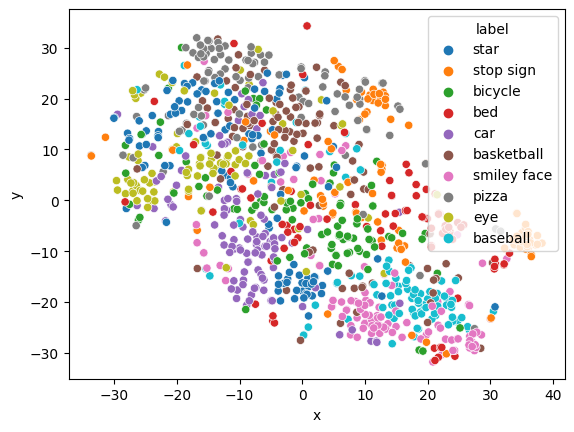

## Correct! 🎉

In [17]:
from sklearn.manifold import TSNE
import seaborn as sns

%matplotlib inline

# TODO: Implement the TSNE function to gather the transformed embeddings.
transformed = TSNE(n_components=2).fit_transform(embeddings[0:1000])
label_names = list(DOODLE_TO_EMOJI_MAP.keys())

# This part is done for you! :)
df = pd.DataFrame([])
df['x'] = transformed[:, 0]
df['y'] = transformed[:, 1]
df['label'] = [label_names[i] for i in labels[0:1000]]
sns.scatterplot(data=df, x='x', y='y', hue='label')
sns.set(rc={"figure.figsize":(16, 8)})
plt.show()

check('3.4.2', df)


Congratulations! You've made it to the end.

To end, we'll pose a simple question. Consider the plot: can you see distinct clusters corresponding to the different classes?